In [2]:
import numpy as np
    

In [3]:
##define the fixed parameters
hatchability = 0.98  #if hatchability is density (egg or adult) depedent, then define it in the pre-adult-module or the adult-module functions 
x1 = 2.5  #parameter in finding the mean larval size
x2 = 1  #parameter in finding the mean larval size 
x3 = 0.009 #parameter in finding the mean larval size 
sigma_size = 0.45  #parameter in assigning larval sizes by drawing from a normal distribution
mc = 1.1 #critical size cut off of the larval stage for successful pupation (= 1.1 (JB) and 1 (FEJ))
x4 = 1.0  #parameter in finding the adult sizes
female_proportion = 0.5 #assign sex to the adutls 
x5 = 85 #parameter in finding fecundity
x6 = 2  #parameter in finding fecundity
sen_adsize = 1.7 #parameter related to sensivity of fecundity to adult size
sen_adden = 0.17 #parameter related to sensivity of fecundity to adult denisity

In [9]:
##Pre-Adult-Module
#food = larval food amt; 1.76 (LL and LH), 2.56 (HL and HH) 

"""  
This function takes the number of eggs in gen t and larval food amount as input and returns the number of adults in gen t and their size distribution as output.

Args: 
    numegg (int): number of eggs in generation t
    food (float): larval food amount in ml

Returns:
    numadult (int): number of adults in generation t
    size_adult_arr (array): size distribution of adults in generation t
"""
def Pre_Adult_Module(numegg,food):
    numlarva = int(hatchability*numegg)
    mean_size = x1*(1-1/(x2+np.exp(-x3*numlarva+food)))
    size_larva_arr = abs(np.random.normal(mean_size, sigma_size, numlarva))
    numadult = (size_larva_arr>=mc).sum()
    size_adult_arr = x4*size_larva_arr[size_larva_arr>=mc]
    return numadult, size_adult_arr

##Demographic-Stochasticity
"""  
This function takes the number of adults in gen t, if their number is less than 8 then it is reduced to 0 by 50 % chance

Args: 
    numadult (int): number of adults in generation t before demographic stochasticity

Returns:
    numadult (int): number of adults in generation t after demographic stochasticity
"""
def Demo_Stoch(numadult):
    if numadult < 8:
        numadult = np.random.binomial(size=1, n=1, p=0.5)*numadult # numadult either remains the same or is reduced to 0
    return numadult



##Adult-Module
#adnut = #adult food nutrition quality; 1 (LL and HL), 1.29 (HH) and 1.49 (LH)
"""  
This function takes the number of adults in gen t, their size distribution and the nutrition quality of adult food as inputs and returns the number of eggs in gen t+1 as output.

Args: 
    numadult (int): number of adults in generation t
    size_adult_arr (array): size distribution of adults in generation t
    adnut (float): adult food nutrition quality

Returns:
    numegg (int): number of eggs in generation t+1
"""
def Adult_Module(numadult, size_adult_arr,adnut):
    if numadult == 0: # if the population goes extinct then restart it with 4 females of size 2*mc
        numadult = 4
        size_female_arr = 2*mc*np.ones(numadult)
    else :    
        adult_sex_arr = np.random.binomial(size=numadult, n=1, p=female_proportion) # 1 is a female and 0 a male
        size_female_arr = size_adult_arr[adult_sex_arr == 1]
    addens_ind_fec_arr = adnut*x5*np.log(x6+sen_adsize*size_female_arr)
    addens_eff = 1/(1+sen_adden*numadult)
    fecundity_arr = addens_ind_fec_arr*addens_eff
    numegg = fecundity_arr.sum()
    return numegg

##Simulation
"""  
This function takes the number of eggs in gen 1, food amount provided to the larvae in each if the successive gens, the adult food nutrition quality in each if the successive gens, number of generations for which each simulation will be run and the number of replicate simulations that will be run as inputs and returns an array of adult population sizes for each generation (each column is a replicate simulation and each row is a generation) and a matrix of extinctions for each replicate

Args: 
    numegg (int): number of eggs in generation 1
    food (float): larval food amount in ml
    adnut (float): adult food nutrition quality
    generations (int): number of generations for which each simulation will be run
    replicates (int): number of replicate simulations that will be run

Returns:
    numadult_matrix (array): array of adult population sizes for each generation (each column is a replicate simulation and each row is a generation)
    extinctions_matrix (array): array of extinctions for each generation {1 if extinction happens and 0 otherwise} (each column is a replicate simulation and each row is a generation)
"""
def Simulation(numegg,food,adnut,generations,replicates):
    numadult_matrix = np.zeros((generations,replicates)) #array to store the number of adults per generation
    extinctions_matrix = np.zeros((generations,replicates)) #array denoting if extinction happened in any given gen
    for i in range(replicates):
        # 1st generation, we start with numegg eggs
        numadult, size_adult_arr = Pre_Adult_Module(numegg,food)
        numadult = Demo_Stoch(numadult)
        if numadult == 0:
            numadult_matrix[0,i] = 4
            extinctions_matrix[0,i] = 1 
        else:
            numadult_matrix[0,i] = numadult
        for j in range(1,generations):
            numegg = Adult_Module(numadult,size_adult_arr,adnut)
            numadult, size_adult_arr = Pre_Adult_Module(numegg,food)
            numadult = Demo_Stoch(numadult)
            if numadult == 0:
                numadult_matrix[j,i] = 4
                extinctions_matrix[j,i] = 1
            else:
                numadult_matrix[j,i] = numadult
    return numadult_matrix,extinctions_matrix

# prob_extinction_n
"""  
This function takes the extinctions_matrix, and the n (number of generations) as input and returns the probability of extinction happening in the first n generations

Args: 
    extinctions_matrix (array): array of extinctions for each generation {1 if extinction happens and 0 otherwise} (each column is a replicate simulation and each row is a generation)
    n (int): first n number of generations   

Returns:
    prob (0 <= float <= 1): rel. freq of replicates in which we did observe an extinction by the nth generation
"""
def prob_extinction_n(extinctions_matrix,n):
    replicates = np.shape(extinctions_matrix)[1]
    col_sum  = extinctions_matrix[0:n,:].sum(axis=0) 
    extinc_repl = (col_sum>=1).sum()
    prob = extinc_repl/replicates
    return prob


#Fluc_Ind
"""  
This function takes a time series (i.e. one of the columns of our numdult matrix) as input and returns the fluctuation index

Args: 
    tim_ser (array) : array of population size (i.e. number of adults) in each generation  

Returns:
    FI (float): Fluctuation index of the time series
"""
def Fluc_Ind(tim_ser):
    T = len(tim_ser)
    Nbar = np.mean(tim_ser)
    FI = 0 #initiate
    for i in range(T-1):
        FI += abs(tim_ser[i+1]-tim_ser[i])
    FI = FI/(T*Nbar)
    return FI


# FI_numadult_matrix
"""  
This function takes numadult_matrix as input and returns the mean and sd of FI across all replicates

Args: 
    numadult_matrix (array): array of adult population sizes for each generation   

Returns:
    FI_mean (float): Mean fluctuation index of all replicates
    FI_sd (float): Sd fluctuation index of all replicates
"""
def FI_numadult_matrix(numadult_matrix):
    FI_arr = np.zeros(np.shape(numadult_matrix)[1])
    for i in range(np.shape(numadult_matrix)[1]):
        FI_arr[i] = Fluc_Ind(numadult_matrix[:,i])
    FI_mean = np.mean(FI_arr)
    FI_std = np.std(FI_arr)
    return FI_mean, FI_std




 

In [6]:
## Run some test simulations
# numegg = 18 (given in sec 2.3.2); rest of the parameters as in paper; run 49 generation 8 replicates simulations for each of the 4 food regimes
numegg = 18
food = [1.76,2.56] #1.76 (LL and LH), 2.56 (HL and HH)
adnut = [1,1.29,1.49] #1 (LL and HL), 1.29 (HH) and 1.49 (LH)
generations = 49
replicates = 8
LH_nadult_matrix,LH_extinctions_matrix = Simulation(numegg,food[0],adnut[2],generations,replicates)
prob_LH_10 = prob_extinction_n(LH_extinctions_matrix,10)
HL_nadult_matrix,HL_extinctions_matrix = Simulation(numegg,food[1],adnut[0],generations,replicates)
prob_HL_10 = prob_extinction_n(HL_extinctions_matrix,10)
LL_nadult_matrix,LL_extinctions_matrix = Simulation(numegg,food[0],adnut[0],generations,replicates)
prob_LL_10 = prob_extinction_n(LL_extinctions_matrix,10)
HH_nadult_matrix,HH_extinctions_matrix = Simulation(numegg,food[1],adnut[1],generations,replicates)
prob_HH_10 = prob_extinction_n(HH_extinctions_matrix,10)






In [1]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

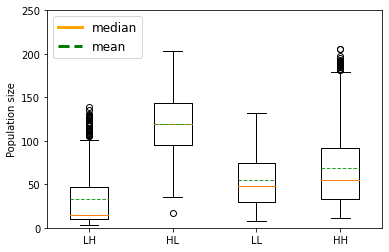

In [8]:
#boxplot of the population sizes
all_points_array = np.column_stack((LH_nadult_matrix.flatten(),HL_nadult_matrix.flatten(),LL_nadult_matrix.flatten(),HH_nadult_matrix.flatten()))
plt.boxplot(all_points_array,meanline=True,showmeans=True)
plt.ylim(0, 250)
plt.xticks([1, 2, 3, 4], ['LH', 'HL', 'LL', 'HH'])
plt.ylabel('Population size')
myHandle = [Line2D([], [], color='orange', lw = 3), Line2D([], [], color='green', linestyle = "dashed", lw = 3)]
plt.legend(handles = myHandle, labels=['median', 'mean'], frameon = True, loc = 'best', fontsize = 12)


In [10]:
###barplot of fluctuation index
LH_FI_mean, LH_FI_sd = FI_numadult_matrix(LH_nadult_matrix)
HL_FI_mean, HL_FI_sd = FI_numadult_matrix(HL_nadult_matrix)
LL_FI_mean, LL_FI_sd = FI_numadult_matrix(LL_nadult_matrix)
HH_FI_mean, HH_FI_sd = FI_numadult_matrix(HH_nadult_matrix)

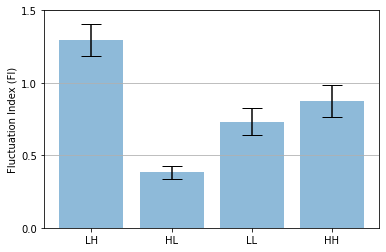

In [11]:
# Create lists for the plot
regimes = ['LH', 'HL', 'LL', 'HH']
x_pos = np.arange(len(regimes))
mean_FI = [LH_FI_mean, HL_FI_mean, LL_FI_mean, HH_FI_mean]
error_FI = [LH_FI_sd, HL_FI_sd, LL_FI_sd, HH_FI_sd]
# Build the plot
fig, ax = plt.subplots()
ax.bar(x_pos, mean_FI, yerr=error_FI, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Fluctuation Index (FI)')
ax.set_xticks(x_pos)
ax.set_xticklabels(regimes)
#ax.set_title('Coefficent of Thermal Expansion (CTE) of Three Metals')
ax.yaxis.grid(True)
plt.yticks(np.arange(0, 2, 0.5))
plt.show()

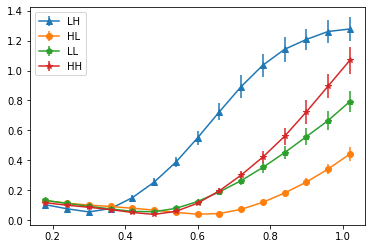

In [13]:
### theoretical study of the effect of life history related parameters (hatchability,mc,sen_adden,,sen_adsize) on FI
generations = 100
replicates = 100
## hatchability
hatchability_arr = np.arange(0.18,1.02,0.06)
FI_hatchability_arr = np.zeros([8,len(hatchability_arr)])
for i in range(len(hatchability_arr)):
    hatchability = hatchability_arr[i]
    LH_nadult_matrix,LH_extinctions_matrix = Simulation(numegg,food[0],adnut[2],generations,replicates)
#prob_LH_10 = prob_extinction_n(LH_extinctions_matrix,10)
    HL_nadult_matrix,HL_extinctions_matrix = Simulation(numegg,food[1],adnut[0],generations,replicates)
#prob_HL_10 = prob_extinction_n(HL_extinctions_matrix,10)
    LL_nadult_matrix,LL_extinctions_matrix = Simulation(numegg,food[0],adnut[0],generations,replicates)
#prob_LL_10 = prob_extinction_n(LL_extinctions_matrix,10)
    HH_nadult_matrix,HH_extinctions_matrix = Simulation(numegg,food[1],adnut[1],generations,replicates)
#prob_HH_10 = prob_extinction_n(HH_extinctions_matrix,10)

    LH_FI_mean, LH_FI_sd = FI_numadult_matrix(LH_nadult_matrix)
    HL_FI_mean, HL_FI_sd = FI_numadult_matrix(HL_nadult_matrix)
    LL_FI_mean, LL_FI_sd = FI_numadult_matrix(LL_nadult_matrix)
    HH_FI_mean, HH_FI_sd = FI_numadult_matrix(HH_nadult_matrix)
    FI_hatchability_arr[0,i] = LH_FI_mean
    FI_hatchability_arr[1,i] = LH_FI_sd
    FI_hatchability_arr[2,i] = HL_FI_mean
    FI_hatchability_arr[3,i] = HL_FI_sd
    FI_hatchability_arr[4,i] = LL_FI_mean
    FI_hatchability_arr[5,i] = LL_FI_sd
    FI_hatchability_arr[6,i] = HH_FI_mean
    FI_hatchability_arr[7,i] = HH_FI_sd
regimes = ['LH', 'HL', 'LL', 'HH']
markers = ['^','o','p','*']
plt.figure()
for i in range(len(regimes)):
    plt.errorbar(hatchability_arr, FI_hatchability_arr[2*i,:],FI_hatchability_arr[2*i+1,:],linestyle='solid', marker=f'{markers[i]}')
plt.legend(regimes)    


    

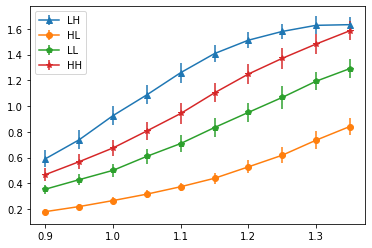

In [14]:
generations = 100
replicates = 100
hatchability = 0.98 #set it back to default value
## MC
MC_arr = np.arange(0.9,1.4,0.05)   
FI_MC_arr = np.zeros([8,len(MC_arr)])
for i in range(len(MC_arr)):
    mc = MC_arr[i]
    LH_nadult_matrix,LH_extinctions_matrix = Simulation(numegg,food[0],adnut[2],generations,replicates)
#prob_LH_10 = prob_extinction_n(LH_extinctions_matrix,10)
    HL_nadult_matrix,HL_extinctions_matrix = Simulation(numegg,food[1],adnut[0],generations,replicates)
#prob_HL_10 = prob_extinction_n(HL_extinctions_matrix,10)
    LL_nadult_matrix,LL_extinctions_matrix = Simulation(numegg,food[0],adnut[0],generations,replicates)
#prob_LL_10 = prob_extinction_n(LL_extinctions_matrix,10)
    HH_nadult_matrix,HH_extinctions_matrix = Simulation(numegg,food[1],adnut[1],generations,replicates)
#prob_HH_10 = prob_extinction_n(HH_extinctions_matrix,10)


    LH_FI_mean, LH_FI_sd = FI_numadult_matrix(LH_nadult_matrix)
    HL_FI_mean, HL_FI_sd = FI_numadult_matrix(HL_nadult_matrix)
    LL_FI_mean, LL_FI_sd = FI_numadult_matrix(LL_nadult_matrix)
    HH_FI_mean, HH_FI_sd = FI_numadult_matrix(HH_nadult_matrix)


    FI_MC_arr[0,i] = LH_FI_mean
    FI_MC_arr[1,i] = LH_FI_sd
    FI_MC_arr[2,i] = HL_FI_mean
    FI_MC_arr[3,i] = HL_FI_sd
    FI_MC_arr[4,i] = LL_FI_mean
    FI_MC_arr[5,i] = LL_FI_sd
    FI_MC_arr[6,i] = HH_FI_mean
    FI_MC_arr[7,i] = HH_FI_sd


regimes = ['LH', 'HL', 'LL', 'HH']
markers = ['^','o','p','*']
plt.figure()
for i in range(len(regimes)):
    plt.errorbar(MC_arr, FI_MC_arr[2*i,:],FI_MC_arr[2*i+1,:],linestyle='solid', marker=f'{markers[i]}')
plt.legend(regimes)    

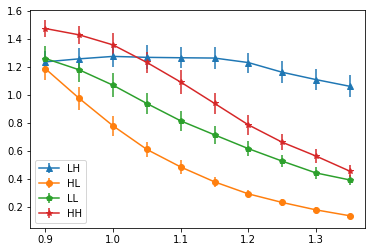

In [15]:
generations = 100
replicates = 100
mc = 1.1 #set it back to default value
## sen_adden
sen_adden_arr = np.arange(0.12,0.22,0.01)
FI_sen_adden_arr = np.zeros([8,len(sen_adden_arr)])
for i in range(len(MC_arr)):
    sen_adden = sen_adden_arr[i]
    LH_nadult_matrix,LH_extinctions_matrix = Simulation(numegg,food[0],adnut[2],generations,replicates)
#prob_LH_10 = prob_extinction_n(LH_extinctions_matrix,10)
    HL_nadult_matrix,HL_extinctions_matrix = Simulation(numegg,food[1],adnut[0],generations,replicates)
#prob_HL_10 = prob_extinction_n(HL_extinctions_matrix,10)
    LL_nadult_matrix,LL_extinctions_matrix = Simulation(numegg,food[0],adnut[0],generations,replicates)
#prob_LL_10 = prob_extinction_n(LL_extinctions_matrix,10)
    HH_nadult_matrix,HH_extinctions_matrix = Simulation(numegg,food[1],adnut[1],generations,replicates)
#prob_HH_10 = prob_extinction_n(HH_extinctions_matrix,10)


    LH_FI_mean, LH_FI_sd = FI_numadult_matrix(LH_nadult_matrix)
    HL_FI_mean, HL_FI_sd = FI_numadult_matrix(HL_nadult_matrix)
    LL_FI_mean, LL_FI_sd = FI_numadult_matrix(LL_nadult_matrix)
    HH_FI_mean, HH_FI_sd = FI_numadult_matrix(HH_nadult_matrix)


    FI_MC_arr[0,i] = LH_FI_mean
    FI_MC_arr[1,i] = LH_FI_sd
    FI_MC_arr[2,i] = HL_FI_mean
    FI_MC_arr[3,i] = HL_FI_sd
    FI_MC_arr[4,i] = LL_FI_mean
    FI_MC_arr[5,i] = LL_FI_sd
    FI_MC_arr[6,i] = HH_FI_mean
    FI_MC_arr[7,i] = HH_FI_sd


regimes = ['LH', 'HL', 'LL', 'HH']
markers = ['^','o','p','*']
plt.figure()
for i in range(len(regimes)):
    plt.errorbar(MC_arr, FI_MC_arr[2*i,:],FI_MC_arr[2*i+1,:],linestyle='solid', marker=f'{markers[i]}')
plt.legend(regimes)    

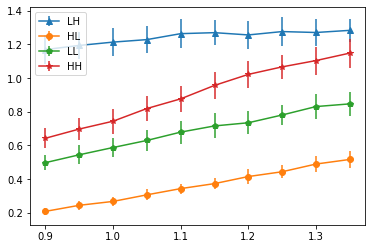

In [16]:
generations = 100
replicates = 100
sen_adden = 0.17 #set it back to default value
## sen_adsize
sen_adsize_arr = np.arange(1.2,2.2,0.1)
FI_sen_adsize_arr = np.zeros([8,len(sen_adsize_arr)])
for i in range(len(MC_arr)):
    sen_adsize = sen_adsize_arr[i]
    LH_nadult_matrix,LH_extinctions_matrix = Simulation(numegg,food[0],adnut[2],generations,replicates)
#prob_LH_10 = prob_extinction_n(LH_extinctions_matrix,10)
    HL_nadult_matrix,HL_extinctions_matrix = Simulation(numegg,food[1],adnut[0],generations,replicates)
#prob_HL_10 = prob_extinction_n(HL_extinctions_matrix,10)
    LL_nadult_matrix,LL_extinctions_matrix = Simulation(numegg,food[0],adnut[0],generations,replicates)
#prob_LL_10 = prob_extinction_n(LL_extinctions_matrix,10)
    HH_nadult_matrix,HH_extinctions_matrix = Simulation(numegg,food[1],adnut[1],generations,replicates)
#prob_HH_10 = prob_extinction_n(HH_extinctions_matrix,10)


    LH_FI_mean, LH_FI_sd = FI_numadult_matrix(LH_nadult_matrix)
    HL_FI_mean, HL_FI_sd = FI_numadult_matrix(HL_nadult_matrix)
    LL_FI_mean, LL_FI_sd = FI_numadult_matrix(LL_nadult_matrix)
    HH_FI_mean, HH_FI_sd = FI_numadult_matrix(HH_nadult_matrix)


    FI_MC_arr[0,i] = LH_FI_mean
    FI_MC_arr[1,i] = LH_FI_sd
    FI_MC_arr[2,i] = HL_FI_mean
    FI_MC_arr[3,i] = HL_FI_sd
    FI_MC_arr[4,i] = LL_FI_mean
    FI_MC_arr[5,i] = LL_FI_sd
    FI_MC_arr[6,i] = HH_FI_mean
    FI_MC_arr[7,i] = HH_FI_sd


regimes = ['LH', 'HL', 'LL', 'HH']
markers = ['^','o','p','*']
plt.figure()
for i in range(len(regimes)):
    plt.errorbar(MC_arr, FI_MC_arr[2*i,:],FI_MC_arr[2*i+1,:],linestyle='solid', marker=f'{markers[i]}')
plt.legend(regimes)    